# Siamese Neural Networks
Recognize images of icebergs from images of ships. 
These images were taken from space with a Sentinel-4 satellite. The goal was to create the most accurate neural network to differentiate them. However, neural networks usually only work well with A LOT of data, and I constrained you guys to 1000 examples to train on. That seems like a lot, but a CONVENTIONAL neural network needs more data. However, we are going to make a special kind of neural network: *Siamese Network*. This special network is used for face recognition and few-shot learning(learning from few examples). Let's get started by importing the usual liraries:

In [0]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D,Activation, Dropout, BatchNormalization,ZeroPadding2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import Adam
from skimage.io import imshow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

Using TensorFlow backend.


## Load the Data


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os

os.chdir('/content/drive/My Drive/AIML/Computer Vision/AdvCompVis/External_lab/')

In [0]:
npz = np.load('input_data.npz')
X_train = npz['X_train']
Y_train = npz['Y_train']
del npz
print ('We have {} examples to work with'.format(Y_train.shape[0]-1000))

We have 3113 examples to work with


## Check the data

Load some of the images to observe how your data look like.

In [0]:
display(X_train.shape,Y_train.shape)

(4113, 75, 75, 3)

(4113,)

In [0]:
np.unique(Y_train)

array([0, 1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


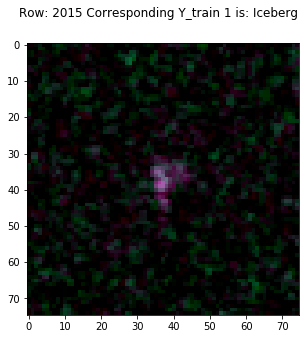

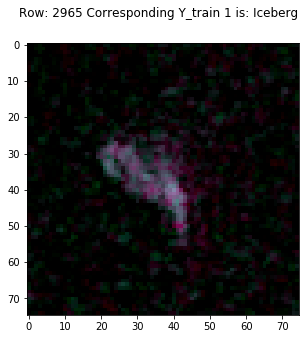

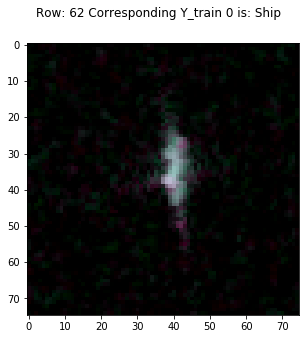

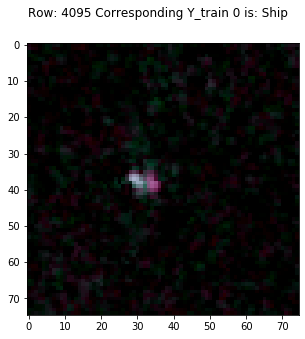

In [0]:
from random import randint

for j in range(0,4):
  #generating random image
  i=randint(0,X_train.shape[0])
  
  plt.figure(figsize=(5,5))
  #Setting Title of the image for corresponding row and Y_train set
  label = ['Ship','Iceberg']  #0 is ship (no iceberg and 1 is iceberg
  plt.suptitle('Row: '+ str(i) +' Corresponding Y_train '+ str(Y_train[i]) +' is: '+ label[(Y_train[i])])
  plt.imshow(X_train[i])

# Creating the structure of Siamese Network

You just need to break it into some steps:
1. 2 Inputs for each images
2. Creating a network which both images will go through individually
3. Couple the network to each input
4. Calculate the L1 distance between them. Just (x1,y1)-(x2,y2)
5. 1 Added layer that will say 1 if they are the same and 0 if they are different

# Create two Inputs for each image - left_input and right_input
Hint - use Input Function in Keras and keep the shape to be 75,75,3

In [0]:
img_h=75
img_w=75
left_input=Ub=Input((img_h,img_w,3))
right_input=Input((img_h,img_w,3))

# Create a base Network in which both images will go through individually.

Hint - Use Sequential Model in Keras with convolution layers, Maxpooling Layers, Flatten Layer and Denser Layer with appropriate activation functions.
Name the network as base_network

In [0]:
input_shape=(img_h,img_w,3)

In [0]:
base_network = Sequential()
base_network.add(Conv2D(5, kernel_size=(3, 3), activation='relu', name='conv1_1', input_shape= input_shape))
#base_network.add(BatchNormalization())
base_network.add(MaxPooling2D())    
#base_network.add(ZeroPadding2D((2, 2)))
    
base_network.add(Conv2D(5, kernel_size=(3, 3), activation='relu', name='conv2_1'))
#base_network.add(BatchNormalization())
base_network.add(MaxPooling2D())
#base_network.add(Dropout(0.3))
#base_network.add(ZeroPadding2D((1, 1)))
    
base_network.add(Conv2D(7, kernel_size=(2, 2), activation='relu', name='conv3_1'))
base_network.add(MaxPooling2D())
#base_network.add(ZeroPadding2D((1, 1)))
    
base_network.add(Conv2D(7, kernel_size=(2, 2), activation='relu', name='conv3_2'))    
#base_network.add(MaxPooling2D((3,3), strides=(2, 2)))
#base_network.add(Dropout(0.3))
base_network.add(Flatten(name='flatten'))
#base_network.add(Dense(1024, activation='relu'))
#base_network.add(Dropout(0.5))
    
base_network.add(Dense(18, activation='sigmoid')) # sigmoid

In [0]:
base_network.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 73, 73, 5)         140       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 5)         0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 34, 34, 5)         230       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 5)         0         
_________________________________________________________________
conv3_1 (Conv2D)             (None, 16, 16, 7)         147       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 7)           0         
_________________________________________________________________
conv3_2 (Conv2D)             (None, 7, 7, 7)          

# Process the left and right inputs to the same Base Network(base_network)

In [0]:
# Connected both left and right input to the same network and note that they have the same weights
processed_a = base_network(left_input)
processed_b = base_network(right_input)

# Get the L1 Distance layer between the 2 processed encodings (processed_a and processed_b)
Hint - You can use Lambda function for this.

In [0]:
# Getting the L1 Distance between the 2 encodings
L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))

# Add the distance function to the network
L1_distance = L1_layer([processed_a, processed_b])

# Add the prediction layer in the end and create the Siamese Network using Model function.

In [0]:
prediction = Dense(1,activation='sigmoid')(L1_distance)

In [0]:
siamese_network = Model(inputs=[left_input,right_input],outputs=prediction)

# Define the Optimizer Adam and Compile the Siamese Model.

In [0]:
optimizer = Adam(lr = 0.00006)
siamese_network.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Show the Summary of your Siamese Network

In [0]:
siamese_network.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 18)           6912        input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 18)           0           sequential_1[1][0]         

# Creating the Pair of Images to train on

It's not time to train though. We still have to create pairs of images to train on. There will be Positive(the same class) or Negative(different classes) for outputs. Let's construct this dataset. It is recommended that there are equal amounts positive and negative.

In [0]:
# First let's separate the dataset from 1 matrix to a list of matricies
image_list = np.split(X_train[:1000],1000)
label_list = np.split(Y_train[:1000],1000)

left_input = []
right_input = []
targets = []

#Number of pairs per image
pairs = 5
#Let's create the new dataset to train on
for i in range(len(label_list)):
    for _ in range(pairs):
        compare_to = i
        while compare_to == i: #Make sure it's not comparing to itself
            compare_to = random.randint(0,999)
        left_input.append(image_list[i])
        right_input.append(image_list[compare_to])
        if label_list[i] == label_list[compare_to]:# They are the same
            targets.append(1.)
        else:# Not the same
            targets.append(0.)
            
left_input = np.squeeze(np.array(left_input))
right_input = np.squeeze(np.array(right_input))
targets = np.squeeze(np.array(targets))

iceimage = X_train[101]
test_left = []
test_right = []
test_targets = []

for i in range(Y_train.shape[0]-1000):
    test_left.append(iceimage)
    test_right.append(X_train[i+1000])
    test_targets.append(Y_train[i+1000])

test_left = np.squeeze(np.array(test_left))
test_right = np.squeeze(np.array(test_right))
test_targets = np.squeeze(np.array(test_targets))

Now we have a lot more examples.
Now we have pairs x 1000 examples to train the network on. 
Each side will have an input of an image and the output will be one if they are the same and zero if not.

# Train the Siamese train on left and right input image pairs created and validate it by test pairs.

In [0]:
from keras.callbacks import ModelCheckpoint
filepath = './best_weights.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='auto',period=1)

In [0]:
 siamese_network.fit([left_input,right_input], targets,
          batch_size=12,
          epochs=10,
          verbose=1,
          validation_data=([test_left,test_right],test_targets),
          callbacks=[checkpoint])

Train on 5000 samples, validate on 3113 samples
Epoch 1/10
5000/5000 [==============================] - 44s 9ms/step - loss: 0.4419 - acc: 0.8072 - val_loss: 0.5483 - val_acc: 0.7639

Epoch 00001: val_acc did not improve from 0.78285
Epoch 2/10
5000/5000 [==============================] - 44s 9ms/step - loss: 0.4373 - acc: 0.8092 - val_loss: 0.5388 - val_acc: 0.7713

Epoch 00002: val_acc did not improve from 0.78285
Epoch 3/10
5000/5000 [==============================] - 44s 9ms/step - loss: 0.4333 - acc: 0.8120 - val_loss: 0.5061 - val_acc: 0.7902

Epoch 00003: val_acc improved from 0.78285 to 0.79023, saving model to ./best_weights.hdf5
Epoch 4/10
5000/5000 [==============================] - 44s 9ms/step - loss: 0.4306 - acc: 0.8114 - val_loss: 0.5158 - val_acc: 0.7851

Epoch 00004: val_acc did not improve from 0.79023
Epoch 5/10
5000/5000 [==============================] - 44s 9ms/step - loss: 0.4273 - acc: 0.8136 - val_loss: 0.5031 - val_acc: 0.7889

Epoch 00005: val_acc did not im

In [0]:
 #The best weights are saved from previus model training with batch_size as 30, now would load the best fit with batch size as 12 and train further
 siamese_network.load_weights('./best_weights.hdf5')
siamese_network.fit([left_input,right_input], targets,
          batch_size=30,
          epochs=15,
          verbose=1,
          validation_data=([test_left,test_right],test_targets),
          callbacks=[checkpoint])

Train on 5000 samples, validate on 3113 samples
Epoch 1/15
5000/5000 [==============================] - 38s 8ms/step - loss: 0.4098 - acc: 0.8270 - val_loss: 0.4977 - val_acc: 0.7967

Epoch 00001: val_acc improved from 0.79537 to 0.79666, saving model to ./best_weights.hdf5
Epoch 2/15
5000/5000 [==============================] - 38s 8ms/step - loss: 0.4083 - acc: 0.8278 - val_loss: 0.5020 - val_acc: 0.7941

Epoch 00002: val_acc did not improve from 0.79666
Epoch 3/15
5000/5000 [==============================] - 38s 8ms/step - loss: 0.4073 - acc: 0.8294 - val_loss: 0.4910 - val_acc: 0.7973

Epoch 00003: val_acc improved from 0.79666 to 0.79730, saving model to ./best_weights.hdf5
Epoch 4/15
5000/5000 [==============================] - 38s 8ms/step - loss: 0.4063 - acc: 0.8294 - val_loss: 0.4950 - val_acc: 0.7983

Epoch 00004: val_acc improved from 0.79730 to 0.79827, saving model to ./best_weights.hdf5
Epoch 5/15
5000/5000 [==============================] - 38s 8ms/step - loss: 0.4048 -